Nas aulas anteriores nós fizemos os testes de hipóteses utilizando técnicas de estatística não paramétrica. Porém, como os resultados dos algoritmos seguem uma distribuição normal (conforme os testes de normalidade realizados), o objetivo desta tarefa é aplicar o ANOVA e também o teste de Tukey para comparar os resultados dos algoritmo

In [104]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from statsmodels.stats.multicomp import MultiComparison

## Treinamento

In [105]:
dataset = pd.read_csv('credit_data.csv')
dataset.dropna(inplace=True)
dataset.head()

,i#clientid,income,age,loan,c#default
0,1,66155.925095,59.017015,8106.532131,0
1,2,34415.153966,48.117153,6564.745018,0
2,3,57317.170063,63.108049,8020.953296,0
3,4,42709.534201,45.751972,6103.642260,0
4,5,66952.688845,18.584336,8770.099235,1


In [106]:
X = dataset.iloc[:, 1:4].values
y = dataset.iloc[:, 4].values

In [107]:
min(X[0]), max(X[0])

(np.float64(59.0170150669292), np.float64(66155.9250950813))

In [108]:
#aplicação do z-score para melhorar o desempenho do algoritmo
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [109]:
min(X[0]), max(X[0])

(np.float64(1.2019070702053862), np.float64(1.4538977547824534))

In [110]:
resultados_naive_cv = []
resultados_logistica_cv = []
resultados_forest_cv = []
for i in range(30):
  kfold = KFold(n_splits = 10, shuffle = True, random_state = i)

  naive_bayes = GaussianNB()
  scores = cross_val_score(naive_bayes, X, y, cv = kfold)
  resultados_naive_cv.append(scores.mean())

  logistica = LogisticRegression()
  scores = cross_val_score(logistica, X, y, cv = kfold)
  resultados_logistica_cv.append(scores.mean())

  random_forest = RandomForestClassifier()
  scores = cross_val_score(random_forest, X, y, cv = kfold)
  resultados_forest_cv.append(scores.mean())

resultados_naive_cv = np.array(resultados_naive_cv)
resultados_logistica_cv = np.array(resultados_logistica_cv)
resultados_forest_cv = np.array(resultados_forest_cv)

In [111]:
resultados_naive_cv.mean(), resultados_logistica_cv.mean(), resultados_forest_cv.mean()

(np.float64(0.9249859296482411),
 np.float64(0.9456840871021776),
 np.float64(0.9871139865996651))

## Teste

### Anova

In [112]:
from scipy.stats import f_oneway
_, p = f_oneway(resultados_naive_cv, resultados_logistica_cv, resultados_forest_cv)
print(p)
'Existe diferença estatística significativa' if p < 0.05 else 'Não existe diferença estatística significativa'

4.035203721525716e-116


'Existe diferença estatística significativa'

### Tukey

In [113]:
#Preparando os dados para turkey e verificando se a lógica funcionou por meio da contagem.
nomes_modelos = ['Naive'] * 30 + ['Logistica'] * 30 + ['Forest'] * 30
contagem = {}
for nomes in nomes_modelos:
    contagem[nomes] =  contagem.get(nomes,0) + 1
print(contagem)

{'Naive': 30, 'Logistica': 30, 'Forest': 30}


In [114]:
resultados_concatenados = np.concatenate([resultados_naive_cv,resultados_logistica_cv, resultados_forest_cv])
resultados_concatenados

array([0.92486181, 0.92491709, 0.92438693, 0.92288191, 0.92487186,
       0.92588945, 0.92438442, 0.92488945, 0.92487186, 0.92388945,
       0.92538442, 0.92440201, 0.92537437, 0.92439447, 0.92488693,
       0.92538191, 0.92588442, 0.92439447, 0.92438191, 0.92588442,
       0.92589447, 0.92538945, 0.92436432, 0.92688442, 0.92339447,
       0.92488945, 0.92488693, 0.92539196, 0.92588442, 0.92638442,
       0.94642714, 0.94640201, 0.94641709, 0.94490955, 0.94591457,
       0.94291709, 0.94541206, 0.94690201, 0.94541457, 0.94392714,
       0.94642462, 0.94542211, 0.94642211, 0.94540201, 0.94440955,
       0.94592211, 0.9459397 , 0.94440955, 0.9453995 , 0.94641709,
       0.94743467, 0.94441206, 0.94642462, 0.94490955, 0.9458995 ,
       0.94592211, 0.9474397 , 0.94542211, 0.94642462, 0.94542211,
       0.98597739, 0.9854799 , 0.9839799 , 0.98696985, 0.98898492,
       0.98798241, 0.98697487, 0.98548492, 0.98747487, 0.98698492,
       0.99048492, 0.98546985, 0.9889799 , 0.98897739, 0.98848

In [115]:
resultados = {'Resultados':resultados_concatenados,
              'Modelo':nomes_modelos}
resultados_df = pd.DataFrame(resultados)

In [116]:
resultados_df.head()

,Resultados,Modelo
0,0.924862,Naive
1,0.924917,Naive
2,0.924387,Naive
3,0.922882,Naive
4,0.924872,Naive


In [119]:
comparacao = MultiComparison(resultados_df['Resultados'],resultados_df['Modelo'])

In [120]:
teste_tukey = comparacao.tukeyhsd()
print(teste_tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj  lower   upper  reject
---------------------------------------------------------
   Forest Logistica  -0.0414   0.0 -0.0422 -0.0407   True
   Forest     Naive  -0.0621   0.0 -0.0629 -0.0614   True
Logistica     Naive  -0.0207   0.0 -0.0215 -0.0199   True
---------------------------------------------------------


Random forest é estatisticamente superior as demais opções.

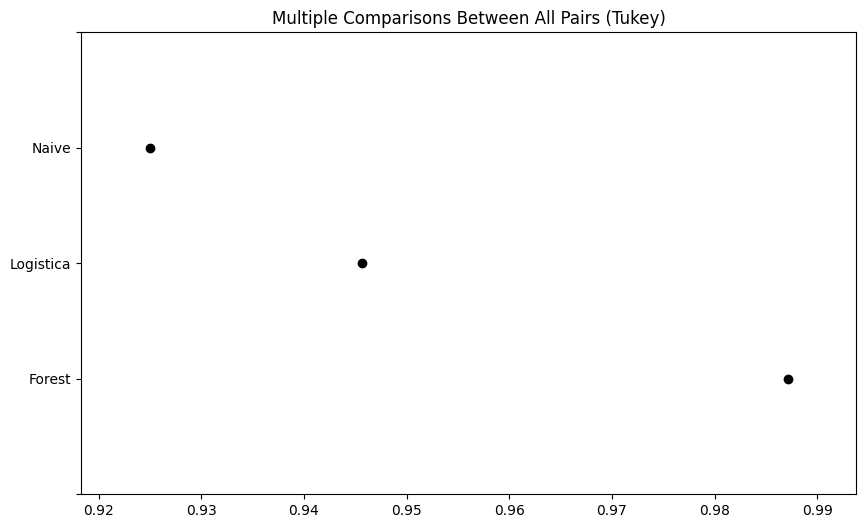

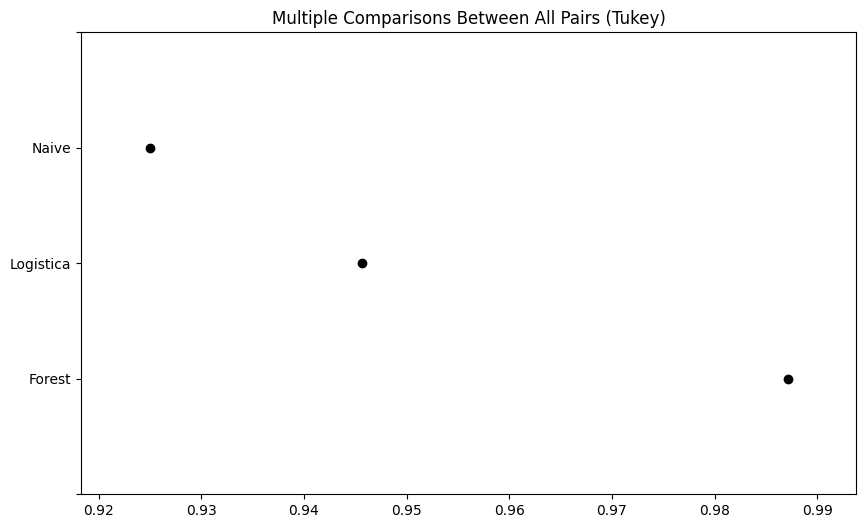

In [122]:
teste_tukey.plot_simultaneous()